In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle

# Load the numpy arrays
X_train_preprocessed = np.load('D:/JATHURSH/Jupyter_notebook_projects/Saved_stuff_from_drowsiness_detection_project/half_data_train_test_validation_split/X_train_preprocessed.npy')

X_test_preprocessed = np.load('D:/JATHURSH/Jupyter_notebook_projects/Saved_stuff_from_drowsiness_detection_project/half_data_train_test_validation_split/X_test_preprocessed.npy')

X_val_preprocessed = np.load('D:/JATHURSH/Jupyter_notebook_projects/Saved_stuff_from_drowsiness_detection_project/half_data_train_test_validation_split/X_val_preprocessed.npy')

y_train = np.load('D:/JATHURSH/Jupyter_notebook_projects/Saved_stuff_from_drowsiness_detection_project/half_data_train_test_validation_split/y_train.npy')

y_test = np.load('D:/JATHURSH/Jupyter_notebook_projects/Saved_stuff_from_drowsiness_detection_project/half_data_train_test_validation_split/y_test.npy')

y_val = np.load('D:/JATHURSH/Jupyter_notebook_projects/Saved_stuff_from_drowsiness_detection_project/half_data_train_test_validation_split/y_val.npy')

In [2]:
# pretrained model - MobileNetV2
# all should be numpy arrays or tensors to give to MobileNetV2
"""
tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=None,                 # Shape of input data (MobileNets support any input size greater than 32 x 32, with larger image sizes offering better performance.) 
    alpha=1.0,                        # Width multiplier for controlling network width (default is 1.0)
    include_top=True,                 # Include fully connected top layers (default is True)
    weights='imagenet',               # Weight initialization ('imagenet' for pre-trained weights, None for random initialization)
    input_tensor=None,                # Optional input tensor (default is None)
    pooling=None,                     # Pooling type for the last layer ('avg', 'max', or None; default is None)
    classes=1000,                     # Number of output classes (default is 1000 for ImageNet)
    classifier_activation='softmax',   # Activation function for output layer (default is 'softmax')
    **kwargs                          # Additional keyword arguments
)
"""
# we dont have to set anything and keep its default values

MobileNetV2_model = tf.keras.applications.mobilenet_v2.MobileNetV2()

# Make all layers in the model non-trainable - freeze
for layer in MobileNetV2_model.layers:
    layer.trainable = False

In [3]:
# Get the base model's input and output
base_input = MobileNetV2_model.layers[0].input
base_output = MobileNetV2_model.layers[-3].output

# custom dense layers
x = tf.keras.layers.GlobalAveragePooling2D()(base_output)
x = tf.keras.layers.Dense(256, activation='relu')(x)  # Add a dense layer with 256 units and ReLU activation
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout for regularization
x = tf.keras.layers.Dense(128, activation='relu')(x)  # Add another dense layer with 128 units and ReLU activation

# Final output layer
final_output = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid activation

In [4]:
drowsiness_detection_model_2 = tf.keras.Model(
    inputs=base_input,
    outputs=final_output
)

In [5]:
drowsiness_detection_model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [7]:
# Compile and train the model using X_train_preprocessed as input
drowsiness_detection_model_2.compile(optimizer='adam', 
                                   loss='binary_crossentropy', 
                                   metrics=['accuracy'])
drowsiness_detection_model_2.fit(X_train_preprocessed, 
                               y_train, 
                               epochs=10, 
                               batch_size=8, 
                               validation_data=(X_val_preprocessed, y_val))

Epoch 1/10
3715/3715 [==============================] - 629s 169ms/step - loss: 0.1417 - accuracy: 0.9489 - val_loss: 0.0893 - val_accuracy: 0.9676
Epoch 2/10
3715/3715 [==============================] - 650s 175ms/step - loss: 0.1021 - accuracy: 0.9636 - val_loss: 0.0799 - val_accuracy: 0.9702
Epoch 3/10
3715/3715 [==============================] - 664s 179ms/step - loss: 0.0907 - accuracy: 0.9675 - val_loss: 0.0815 - val_accuracy: 0.9724
Epoch 4/10
3715/3715 [==============================] - 661s 178ms/step - loss: 0.0835 - accuracy: 0.9701 - val_loss: 0.0746 - val_accuracy: 0.9741
Epoch 5/10
3715/3715 [==============================] - 663s 178ms/step - loss: 0.0778 - accuracy: 0.9727 - val_loss: 0.0715 - val_accuracy: 0.9739
Epoch 6/10
3715/3715 [==============================] - 662s 178ms/step - loss: 0.0736 - accuracy: 0.9743 - val_loss: 0.0704 - val_accuracy: 0.9755
Epoch 7/10
3715/3715 [==============================] - 662s 178ms/step - loss: 0.0710 - accuracy: 0.9738 - val_

In [8]:
#  predict on test data
y_pred = drowsiness_detection_model_2.predict(X_test_preprocessed)

199/199 [==============================] - 161s 793ms/step


In [9]:
# check first 10 predictions
y_pred[:20]

array([[1.0000000e+00],
       [8.3551508e-01],
       [4.1562089e-07],
       [3.4406185e-05],
       [4.5625400e-02],
       [1.3855875e-03],
       [9.9998194e-01],
       [5.2830569e-07],
       [9.7932255e-01],
       [1.9391460e-05],
       [1.0000000e+00],
       [9.9999917e-01],
       [1.4528827e-07],
       [2.9141662e-01],
       [1.8124563e-05],
       [6.4527318e-05],
       [4.8605225e-06],
       [3.7624359e-01],
       [9.8699403e-01],
       [9.9990863e-01]], dtype=float32)

In [10]:
# Round the predicted probabilities to 0 or 1
y_pred_binary = (y_pred >= 0.5).astype(int)

# Now, y_pred_binary contains binary predictions (0 or 1) based on the 0.5 threshold

In [12]:
from sklearn.metrics import accuracy_score

# y_pred_binary contains the predicted labels (0 or 1)
accuracy = accuracy_score(y_test, y_pred_binary)
accuracy_percentage = accuracy * 100
accuracy_percentage

97.58165829145729

In [13]:
# Save the model
drowsiness_detection_model_2.save('drowsiness_detection_model_2.h5')

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
image = cv2.imread("D:/JATHURSH/Jupyter_notebook_projects/DeepLearning/driving-man-2.jpg")

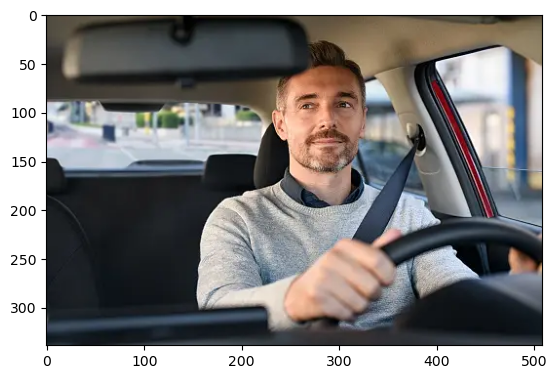

In [18]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [19]:
# Convert the image to grayscale (required for face and eye detection)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [21]:
# Load the pre-trained Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the pre-trained Haar Cascade classifier for eye detection
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [22]:
# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

In [23]:
# Initialize a list to store cropped eye images
eye_images = []

# Loop over detected faces
for (x, y, w, h) in faces:
    # Draw a rectangle around the face
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Crop the face region for eye detection
    roi_gray = gray[y:y + h, x:x + w]
    roi_color = image[y:y + h, x:x + w]
    
    # Detect eyes in the face region
    eyes = eye_cascade.detectMultiScale(roi_gray)
    
    # Loop over detected eyes and draw rectangles
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (255, 0, 0), 2)
        # Crop the eye region and store it in the list 
        eye_roi = roi_gray[ey:ey + eh, ex:ex + ew]
        eye_images.append(eye_roi)

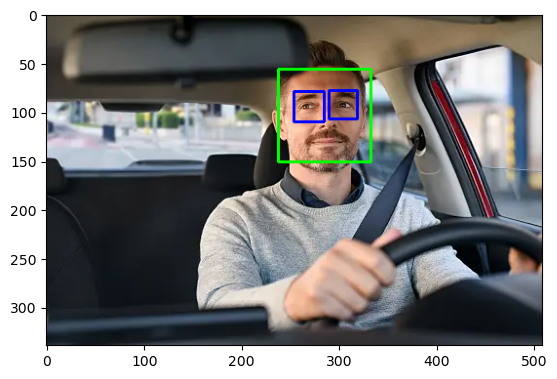

In [25]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

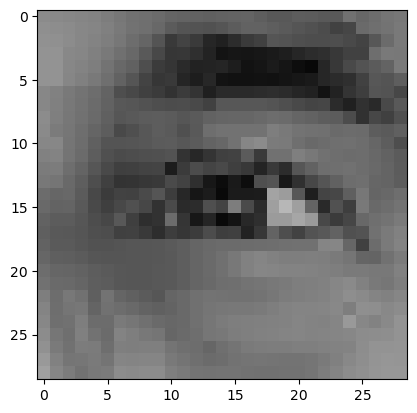

In [26]:
plt.imshow(cv2.cvtColor(eye_images[0], cv2.COLOR_BGR2RGB))

In [30]:
# Convert the grayscale image to RGB format
rgb_image = cv2.cvtColor(eye_images[0], cv2.COLOR_GRAY2RGB)

In [31]:
# Resize the image to 224x224 pixels
image_resized = cv2.resize(rgb_image, (224, 224))

# Adding the 4th dimension for compatibility with the mobileNetV2 model
final_image = np.expand_dims(image_resized, axis=0)

# Normalize - using the same mobileNetV2's preprocess_input method
final_image_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(final_image)

In [34]:
final_image_preprocessed.shape

(1, 224, 224, 3)

In [36]:
final_image_preprocessed[:3]

array([[[[ 0.09019613,  0.09019613,  0.09019613],
         [ 0.09019613,  0.09019613,  0.09019613],
         [ 0.09019613,  0.09019613,  0.09019613],
         ...,
         [-0.06666666, -0.06666666, -0.06666666],
         [-0.06666666, -0.06666666, -0.06666666],
         [-0.06666666, -0.06666666, -0.06666666]],

        [[ 0.09019613,  0.09019613,  0.09019613],
         [ 0.09019613,  0.09019613,  0.09019613],
         [ 0.09019613,  0.09019613,  0.09019613],
         ...,
         [-0.06666666, -0.06666666, -0.06666666],
         [-0.06666666, -0.06666666, -0.06666666],
         [-0.06666666, -0.06666666, -0.06666666]],

        [[ 0.09019613,  0.09019613,  0.09019613],
         [ 0.09019613,  0.09019613,  0.09019613],
         [ 0.09019613,  0.09019613,  0.09019613],
         ...,
         [-0.06666666, -0.06666666, -0.06666666],
         [-0.06666666, -0.06666666, -0.06666666],
         [-0.06666666, -0.06666666, -0.06666666]],

        ...,

        [[ 0.254902  ,  0.254902  ,  0

In [37]:
y_pred_of_image = drowsiness_detection_model_2.predict(final_image_preprocessed)

1/1 [==============================] - 2s 2s/step


In [38]:
y_pred_binary = (y_pred_of_image >= 0.5).astype(int)
y_pred_binary

array([[1]])

In [ ]:
# 0 - closed
# 1 - open